In [1088]:
import random

In [725]:
import pandas as pd
from pandas_datareader import data
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np


# Upload .csv files and convert to dataframe
df = pd.read_csv("~/Downloads/shot_logs.csv")
player_df = pd.read_csv("~/Downloads/players_stats.csv")
player_df.rename(columns={'Name':'player_name'},inplace=True)

# Change format of name to match
df["player_name"] = df["player_name"].str.title()


In [884]:
# Function that cleans the dataframes' dirty values.
def initialize():
    # DATA CALL, MATCH --> calling the .csv files, renaming so the column names are the same
    df = pd.read_csv("~/Downloads/shot_logs.csv")
    player_df = pd.read_csv("~/Downloads/players_stats.csv")
    player_df.rename(columns={'Name':'player_name'},inplace=True)

    df["player_name"] = df["player_name"].str.title()

    # GAME CLOCK --> changing the string format into integer
    df["GAME_CLOCK_SEC"] = df["GAME_CLOCK"].str.slice(start=-2)         # Game clock's YY
    df["GAME_CLOCK_MIN"] = df["GAME_CLOCK"].str.slice(start=0,stop=-3)  # Game clock's XX

    df["GAME_CLOCK_SEC"] = df["GAME_CLOCK_SEC"].astype(int)
    df["GAME_CLOCK_MIN"] = df["GAME_CLOCK_MIN"].astype(int)

    df["GAME_CLOCK_INT"] = df["GAME_CLOCK_SEC"] + df["GAME_CLOCK_MIN"] * 60

    df = df.drop(["GAME_CLOCK_SEC", "GAME_CLOCK_MIN"],axis=1)

    # Changing the buzzer beater SHOT_CLOCK to 0.0 (is originally NaN)
    df.loc[df["GAME_CLOCK_INT"]==0,"SHOT_CLOCK"] = 0.0

    
    # PLAYER NAME CLEANING
    # Adding another name format as list. Ex) Stephen Curry --> ['Stephen', 'Curry']
    df["CLOSEST_DEFENDER_list"] = df["CLOSEST_DEFENDER"].str.split(pat = ", ")

    # Nene Hilario is sometimes enlisted as Nene in the data, fixing it.
    player_df.loc[player_df["player_name"]=='Nene',"player_name"] = 'Nene Hilario'
    df.loc[df["CLOSEST_DEFENDER"]=='Nene','CLOSEST_DEFENDER'] = 'Nene Hilario'

    df.drop("CLOSEST_DEFENDER_list",axis=1,inplace=True)
    
    
    # MERGING DATAFRAMES
    # Merge by name
    combo = pd.merge(df, player_df,
                    on= 'player_name',
                    how= 'left',
                    indicator=True)

    # Changing the same variable names 
    # (_shot --> var that describes one shot. _all --> var that describes all shots by player generally)
    combo.rename(columns={'FGM_x':'FGM_shot','PTS_x':'PTS_shot','FGM_y':'FGM_all','PTS_y':'PTS_all'},inplace=True)

    combo['FGAPG'] = combo['FGA'] / combo['Games Played'] # Field Goals Attempted Per Game

initialize()

In [630]:
# FUNCTIONS THAT HELP DICTIONARY

# add_dict(x,d) is used when dictionary is used as 'many count variables'
def add_dict(x,dictionary):
    if x in dictionary.keys():
        dictionary[x] += 1
    else:
        dictionary[x] = 1
        
# sort_dict(d) can sort the dictionary by the key values       
def sort_dict(dictionary):
    new_dict = {}
    for key in sorted(dictionary.keys()) :
        new_dict[key] = dictionary[key]
    
    return new_dict

In [1153]:
# SAMPLING TOOL

# Selecting random indexes for list (sampling)
def sample_ind_choosing(lst,sample_amount):
    length = len(lst) # Length of list
    sample_inds = []

    population = list(range(length)) # Whole population

    for x in range(sample_amount):
        random_index = random.choice(population)
        sample_inds.append(random_index)
        population.remove(random_index)
        
    return sample_inds
    


In [1016]:
# All of the names from DataFrame (NBA 2k14)
names = list(dict.fromkeys(combo["player_name"].tolist()))

In [1147]:
# All of the teams from DataFrame (NBA 2k14)
teams_list = list(dict.fromkeys(combo["Team"].tolist()))
teams_list.pop(1) # Starngely, in there is a NaN team in the first index.

# Making a teams dictionary where there are player names inside the teams
teams_dict = {}
for team in teams_list: # Putting in names by team
    names = list(dict.fromkeys(combo[combo['Team']==team]["player_name"].tolist()))
    teams_dict[team] = names

In [967]:
name = "Stephen Curry"
if len(combo[combo['player_name']==name]) == 0:
    print("That name is not enlisted in NBA. Perhaps spelled it wrong?")

In [1144]:
team = 'GSW'
if not team in teams:
    print("That team is not enlisted in NBA. Perhaps spelled it wrong?")

###  Hot Hand : 
##### A phenomenon in which a player who has previously put shots in is more likely to score the next shot

In [885]:
""" Calculation done with STREAK, find out this calculation is filled with BS """
def accuracy(name):
    return combo[combo["player_name"]==name]["FG%"].tolist()[0]

# Chronologically Looking the Shots.

def actual(name):
    game_ids = list(dict.fromkeys(combo["GAME_ID"].tolist()))

    counter_dict = {}

    for game_id in game_ids:
        test_df = combo[(combo["GAME_ID"]==game_id) & (combo["player_name"]==name)]
        list_bin = test_df["FGM_shot"].tolist()

        streak = []
        for x in range(len(list_bin)):
            streak.append(None)

        for x in range(len(list_bin)):
            if list_bin[x] == 0:
                streak[x] = 0
            elif x == 0:
                streak[x] = 1
            else:
                streak[x] = streak[x-1]+1

        for element in streak:
            add_dict(element,counter_dict)
        
    return counter_dict

def ideal(name,maximum):
    iso_dict = {}
    for x in range(maximum):
        iso_dict[x] = len(combo[combo["player_name"]==name]) * (1-accuracy(name)/100) * ((accuracy(name)/100)**x)
    return iso_dict
        

print(accuracy(name))
print(sort_dict(actual(name)))
print(ideal(name,len(actual(name))))


43.9
{0: 339, 1: 164, 2: 58, 3: 26, 4: 12, 5: 4, 6: 3, 7: 2, 8: 2, 9: 1, 10: 1}
{0: 343.332, 1: 150.722748, 2: 66.167286372, 3: 29.047438717308, 4: 12.751825596898211, 5: 5.598051437038315, 6: 2.45754458085982, 7: 1.0788620709974612, 8: 0.4736204491678854, 9: 0.20791937718470171, 10: 0.09127660658408404}


In [1042]:
def hot_hand_condi(name,streak=2):  
    
    #  P(n_hits ∩ next_hit)
    #  --------------------
    #       P(n_hits)
    game_ids = list(dict.fromkeys(combo["GAME_ID"].tolist())) # All of the game_ids

    all_hits = 0   # All hits by the player
    condi_hits = 0 # Hits when previous shots were hits, resulting a hit streak of "'streak'"
    
    for game_id in game_ids: # Iterating game_ids
        players_shots_df = combo[(combo["GAME_ID"]==game_id) & (combo["player_name"]==name)] # Selecting the right rows
            
        bin_list = players_shots_df["FGM_shot"].tolist() # List of 0,1. 1 means put in, 0 means miss
        check_bool = 1
        
        for result in range(len(bin_list)-streak+1):
            check_bool = 1
            for i in range(streak-1): # Checking for hit streak of previously put in shots
                if not bin_list[result+i]:
                    check_bool = 0
            if check_bool: # If streak is true, denominator all_hits increases by 1
                all_hits += 1
                
            check_bool = 1
            for i in range(streak): # Checking for hit streak of previously put in shots AND the next shot
                if not bin_list[result+i]:
                    check_bool = 0
            if check_bool: # If the streak is true, numerator condi_hits increases by 1
                condi_hits += 1
    return condi_hits/all_hits


def shot_hit_rate(name):
    # Player's accuracy of putting in shot
    game_ids = list(dict.fromkeys(combo["GAME_ID"].tolist()))

    hits = 0 # All hits by the player

    for game_id in game_ids:
        players_shots_df = combo[(combo["GAME_ID"]==game_id) & (combo["player_name"]==name)]
        list_bin = players_shots_df["FGM_shot"].tolist()
        
        for result in list_bin:
            if result:
                hits += 1
    
    return hits/len(combo[combo["player_name"]==name])
    
    
    
print(hot_hand_condi(name,2))
print(shot_hit_rate(name))


0.44469525959367945
0.4855371900826446


In [1075]:
def shot_hit_per_game(name,streak=2): # Returns a list of tuples. One (hot_hand_condi, shot_hit_rate) tuple per game
    game_ids = list(dict.fromkeys(combo["GAME_ID"].tolist()))

        
    counter_dict = {}
    prob_data = []
    
    hit_rate = shot_hit_rate(name)

    for game_id in game_ids:
        all_hits = 0
        condi_hits = 0
    
        players_shots_df = combo[(combo["GAME_ID"]==game_id) & (combo["player_name"]==name)]
        bin_list = players_shots_df["FGM_shot"].tolist()
        
        for result in range(len(bin_list)-streak+1):
            check_bool = 1
            for i in range(streak-1): 
                if result+i >= len(bin_list):
                    check_bool = 0
                    break
                if not bin_list[result+i]:
                    check_bool = 0
            if check_bool:
                all_hits += 1
                
            check_bool = 1
            for i in range(streak):
                if result+i >= len(bin_list):
                    check_bool = 0
                    break
                if not bin_list[result+i]:
                    check_bool = 0
            if check_bool:
                condi_hits += 1
    
        condi_prob = 0
        if all_hits == 0:
            condi_prob = 0
        else:
            condi_prob = condi_hits / all_hits
        
        # Only using as data when shots attempted is not too low
        if len(bin_list) >= combo[combo['player_name']==name]['FGAPG'].tolist()[0]:
            prob_data.append((condi_prob, hit_rate))
        
    return prob_data

    
print(shot_hit_per_game(name,3))

[(1.0, 0.4855371900826446), (0.25, 0.4855371900826446), (0.6666666666666666, 0.4855371900826446), (0.5, 0.4855371900826446), (0.375, 0.4855371900826446), (0.0, 0.4855371900826446), (0.4, 0.4855371900826446), (0.75, 0.4855371900826446), (0.0, 0.4855371900826446), (0.0, 0.4855371900826446), (0.5555555555555556, 0.4855371900826446), (0.75, 0.4855371900826446), (0.5, 0.4855371900826446), (0.6, 0.4855371900826446), (0.3333333333333333, 0.4855371900826446), (0.0, 0.4855371900826446), (0.6666666666666666, 0.4855371900826446), (0.6, 0.4855371900826446), (0.16666666666666666, 0.4855371900826446), (0.0, 0.4855371900826446), (0.4, 0.4855371900826446), (0.0, 0.4855371900826446), (0.5, 0.4855371900826446), (0.3333333333333333, 0.4855371900826446), (0.3333333333333333, 0.4855371900826446), (0.3333333333333333, 0.4855371900826446), (0.0, 0.4855371900826446), (0.5, 0.4855371900826446), (0.5714285714285714, 0.4855371900826446), (0.3333333333333333, 0.4855371900826446), (0.5, 0.4855371900826446), (0.0, 

In [1019]:
# Checks how many games were hot, not, or in the middle by one player
def hot_games_count(name,streak=2):
    count = {'Hot':0,'Not':0,'Equ':0}
    # Checking if the games by the player were hot, not, or in the middle
    for iter in shot_hit_per_game(name,streak):
        if iter[0]==0 and iter[1]==0:
            continue
        if iter[0] > iter[1]:
            count['Hot'] += 1
        elif iter[0]==iter[1]:
            count['Equ'] += 1
        else:
            count['Not'] += 1
            
    return count

print(hot_games_count(name,4))    

# Calculates the probability of one player to be hot in a game using the function above
def hot_games_quantified(name,streak=2):
    newdict = hot_games_count(name,streak)
    
    total = newdict['Hot']+newdict['Not']+newdict['Equ']
    if total == 0: # divide by 0 exceptional case is returned as None.
        return None
    return newdict['Hot'] / total

print(hot_games_quantified(name,1))

{'Hot': 12, 'Not': 11, 'Equ': 0}
0.0


In [1149]:
def team_average_hot(team,streak=2):
    players = teams_dict[team]
    add = 0 # Used for calculating mean
    for name in players:
        quantified = hot_games_quantified(name,streak)
        if quantified != None:
            add += quantified
    
    mean = add / len(players)
    return mean

In [1155]:
streak = 2
# Using team_average_hot()
teams_hot_mean = {}
for team in ['CLE','GSW']:
    teams_hot_mean[team] = []
for team in ['CLE','GSW']: # Putting in quantified by team
    teams_hot_mean[team].append(team_average_hot(team,streak))

In [1160]:
df_team = pd.DataFrame(teams_hot_mean)
df_team

,CLE,GSW
0,0.366554,0.518047


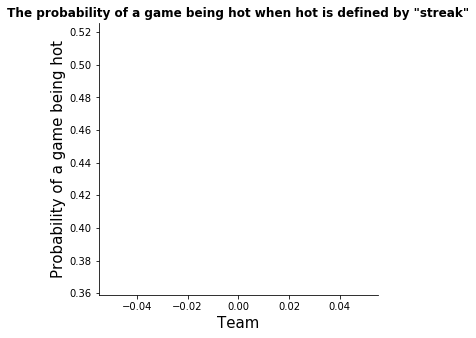

var Streak: the streak of hits when putting in a shot when previous shots were hits


In [1158]:
fig, ax = plt.subplots(1,1,figsize=(5,5))


plt.plot(df_team)
plt.xlabel('Team', fontsize=15)
plt.ylabel('Probability of a game being hot', fontsize=15)
plt.title('The probability of a game being hot when hot is defined by "streak"',fontweight='bold')


plt.show()
print('var Streak: the streak of hits when putting in a shot when previous shots were hits')

In [1110]:
conditional_dict = {2:0,3:0,4:0,5:0,6:0,7:0} # Conditional probability data is iterated in dictionary,
conditional_list = [] # Then moved into a list


for iter_name in sample:
    for x in range(2,8):
        quantified = hot_games_quantified(iter_name,x)
        if quantified != None: # Checks if not exceptional divied by 0 case
            conditional_dict[x] += quantified

for x in range(2,8):
    conditional_list.append(conditional_dict[x]/60)
    
df1 = pd.DataFrame({'Conditional Prob':conditional_list})
print(conditional_list)

KeyboardInterrupt: 

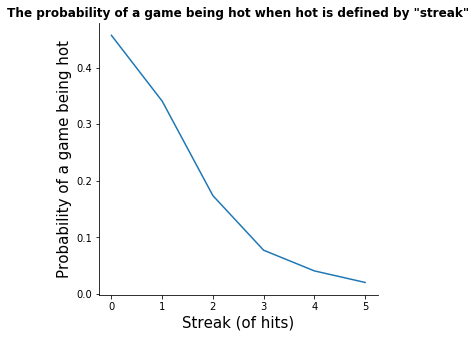

var Streak: the streak of hits when putting in a shot when previous shots were hits


In [1146]:
fig, ax = plt.subplots(1,1,figsize=(5,5))


plt.plot(df1)
plt.xlabel('Streak (of hits)', fontsize=15)
plt.ylabel('Probability of a game being hot', fontsize=15)
plt.title('The probability of a game being hot when hot is defined by "streak"',fontweight='bold')


plt.show()
print('var Streak: the streak of hits when putting in a shot when previous shots were hits')

###  Cold Hand :
##### A made-up phenomenon that is the opposite of Hot Hand -- being likely to miss the next shot when the previous shots were missed.

In [958]:
def cold_hand_condi(name,streak=2):
    
    #  P(n_misses ∩ next_miss)
    #  -----------------------
    #        P(n_misses)
    game_ids = list(dict.fromkeys(combo["GAME_ID"].tolist())) # All of the game_ids

    all_misses = 0   # All misses by the player
    condi_misses = 0 # Misses when previous shots were misses, resulting a miss streak of "'streak'"
        
    counter_dict = {}

    for game_id in game_ids: # Iterating game_ids
        test_df = combo[(combo["GAME_ID"]==game_id) & (combo["player_name"]==name)] # Selecting the right rows
        
        bin_list = test_df["FGM_shot"].tolist() # List of 0,1. 1 means put in, 0 means miss
        check_bool = 1
        
        for result in range(len(bin_list)-streak+1):
            check_bool = 1
            for i in range(streak-1): # Checking for miss streak of previously put in shots
                if bin_list[result+i]:
                    check_bool = 0
            if check_bool: # If streak is true, denominator all_misses increases by 1
                all_misses += 1
                
            check_bool = 1
            for i in range(streak): # Checking for miss streak of previously put in shots AND the next shot
                if bin_list[result+i]:
                    check_bool = 0
            if check_bool: # If streak is true, numerator condi_misses increases by 1
                condi_misses += 1
    
    return condi_misses/all_misses


def shot_miss_rate(name):
    # Player's accuracy of putting in shot
    game_ids = list(dict.fromkeys(combo["GAME_ID"].tolist()))

    misses = 0
        
    counter_dict = {}

    for game_id in game_ids:
        players_shots_df = combo[(combo["GAME_ID"]==game_id) & (combo["player_name"]==name)]
        list_bin = players_shots_df["FGM_shot"].tolist()
        
        for result in list_bin:
            if result == 0:
                misses += 1
    
    return misses/len(combo[combo["player_name"]==name])
    
    
    

print(cold_hand_condi(name,3))
print(shot_miss_rate(name))


0.5948905109489051
0.5679513184584178


In [963]:
def shot_miss_per_game(name,streak=2): # Returns a list of tuples. One (hot_hand_condi, shot_hit_rate) tuple per game
    game_ids = list(dict.fromkeys(combo["GAME_ID"].tolist()))

    counter_dict = {}
    prob_data = []

    for game_id in game_ids:
        all_hits = 0
        condi_hits = 0
    
        players_shots_df = combo[(combo["GAME_ID"]==game_id) & (combo["player_name"]==name)]
        bin_list = players_shots_df["FGM_shot"].tolist()
        
        for result in range(len(bin_list)-streak+1):
            check_bool = 1
            for i in range(streak-1):
                if result+i >= len(bin_list):
                    check_bool = 0
                    break
                if bin_list[result+i]:
                    check_bool = 0
            if check_bool:
                all_hits += 1
                
            check_bool = 1
            for i in range(streak):
                if result+i >= len(bin_list):
                    check_bool = 0
                    break
                if bin_list[result+i]:
                    check_bool = 0
            if check_bool:
                condi_hits += 1
    
        condi_prob = 0
        if all_hits == 0:
            condi_prob = 0
        else:
            condi_prob = condi_hits / all_hits
        
        # Only using as data when shots attempted is not lower than FGAPG (mean)
        if len(bin_list) >= combo[combo['player_name']==name]['FGAPG'].tolist()[0]:
            prob_data.append((condi_prob, all_hits/len(bin_list)))
        
    return prob_data

    
print(shot_miss_per_game(name,2))

[(0.625, 0.47058823529411764), (0.375, 0.38095238095238093), (0.3333333333333333, 0.35294117647058826), (0.3, 0.43478260869565216), (0.4444444444444444, 0.42857142857142855), (0.7692307692307693, 0.7222222222222222), (0.7692307692307693, 0.65), (0.6, 0.5555555555555556), (0.3333333333333333, 0.45), (0.5454545454545454, 0.6111111111111112), (0.5, 0.5833333333333334), (0.5454545454545454, 0.5789473684210527), (0.7857142857142857, 0.7368421052631579), (0.6428571428571429, 0.6363636363636364), (0.7857142857142857, 0.6086956521739131), (0.6666666666666666, 0.5294117647058824), (0.6470588235294118, 0.6538461538461539), (0.3076923076923077, 0.4482758620689655), (0.4, 0.5555555555555556), (0.42857142857142855, 0.4117647058823529), (0.5454545454545454, 0.5), (0.7333333333333333, 0.6818181818181818), (0.5, 0.47058823529411764), (0.6666666666666666, 0.631578947368421), (0.42857142857142855, 0.3888888888888889), (0.7, 0.5882352941176471), (0.6923076923076923, 0.6842105263157895), (0.66666666666666

In [990]:
def cold_games_count(name,streak=2):
    # Checking if the games by the player were cold, not, or in the middle
    count = {'Cold':0,'Not':0,'Equ':0}
    for iter in shot_miss_per_game(name,streak):
        if iter[0] > iter[1]:
            count['Cold'] += 1
        elif iter[0]==iter[1]:
            count['Equ'] += 1
        else:
            count['Not'] += 1

    return count

print(cold_games_count(name,3))

def cold_games_quantified(name,streak=2):
    dict = cold_games_count(name,streak)
    return dict['Cold'] / (dict['Cold']+dict['Not']+dict['Equ'])


{'Cold': 25, 'Not': 7, 'Equ': 0}


In [882]:
names = list(dict.fromkeys(combo["player_name"].tolist()))
hot = []
cold = []
for name in names:
    hotness = hot_count(name)
    if hotness['Hot'] > hotness['Not']:
        hot.append(name)
    
    coldness = cold_count(name)
    if coldness['Cold'] > coldness['Not']:
        cold.append(name)
        
print(hot)
print(cold)

['Al Jefferson', 'Gerald Henderson', 'Gordon Hayward', 'Trevor Booker', 'Enes Kanter', 'Dante Exum', 'Rudy Gobert', 'Carlos Boozer', 'Jeremy Lin', 'Ed Davis', 'Jordan Hill', 'Harrison Barnes', 'Leandro Barbosa', 'Stephen Curry', 'Marreese Speights', 'Andrew Bogut', 'Draymond Green', 'Al Horford', 'Dennis Schroder', 'Paul Millsap', 'Pero Antic', 'Kent Bazemore', 'Mike Scott', 'Andre Miller', 'Paul Pierce', 'Omer Asik', 'Jrue Holiday', 'Ryan Anderson', 'Tyreke Evans', 'Luke Babbitt', 'Anthony Davis', 'Kyle Lowry', 'Amir Johnson', 'James Johnson', 'Jonas Valanciunas', 'Patrick Patterson', 'Tyson Chandler', 'Devin Harris', 'Richard Jefferson', 'Victor Oladipo', 'Elfrid Payton', 'Nikola Vucevic', 'Kyrie Irving', 'Tristan Thompson', 'Luis Scola', 'Damjan Rudez', 'Avery Bradley', 'Tyler Zeller', 'Jeff Green', 'Cory Joseph', 'Boris Diaw', 'Danny Green', 'Tony Parker', 'Nate Robinson', 'Timofey Mozgov', 'Jusuf Nurkic', 'Darrell Arthur', 'Goran Dragic', 'Marcus Morris', 'Alex Len', 'Markieff Mor

### This is another project that is irrelevant to the main project Hot Hand.

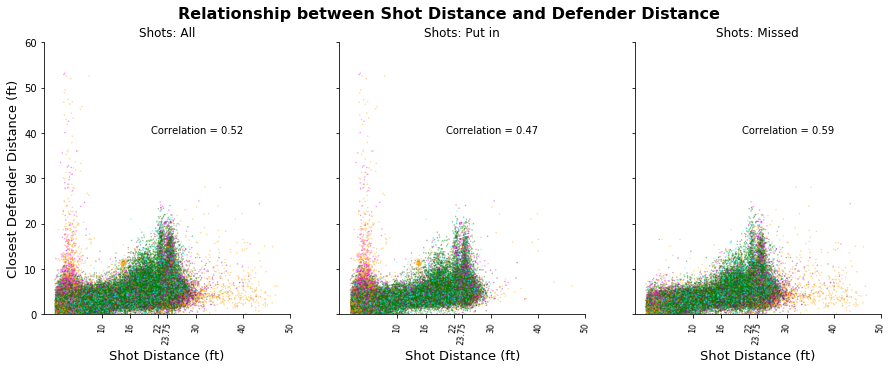

Shot Clock: 0 -------- 3 -------- 6 -------- 9 ----------------------------- 18 ------- 21 ------- 24
Color:         purple      blue       cyan                 green                magenta     orange


In [475]:
df = pd.read_csv("~/Downloads/shot_logs.csv")

fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))
plt.suptitle("Relationship between Shot Distance and Defender Distance",fontweight='bold',fontsize=16)

x = [10,16,22,23.75,30,40,50]


col = np.where(df["SHOT_CLOCK"]<=3,'purple', np.where(df["SHOT_CLOCK"]<=6,'brown', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18,'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[0].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[0].set_title("Shots: All")
axs[0].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[0].set_ylabel("Closest Defender Distance (ft)",fontsize=13)
axs[0].set_xticks(x)
axs[0].set_ylim(0,60)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[0].text(40, 40, message, horizontalalignment='right')

df = df[df["FGM"]==1]

col = np.where(df["SHOT_CLOCK"]<=3,'purple', np.where(df["SHOT_CLOCK"]<=6,'brown', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18, 'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[1].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[1].set_title("Shots: Put in")
axs[1].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[1].text(40, 40, message, horizontalalignment='right')


df = pd.read_csv("~/Downloads/shot_logs.csv")
df = df[df["FGM"]==0]

col = np.where(df["SHOT_CLOCK"]<=3,'purple', np.where(df["SHOT_CLOCK"]<=6,'brown', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18, 'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[2].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[2].set_title("Shots: Missed")
axs[2].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[2].text(40, 40, message, horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

print("Shot Clock: 0 -------- 3 -------- 6 -------- 9 ----------------------------- 18 ------- 21 ------- 24")
print("Color:         purple      blue       cyan                 green                magenta     orange")

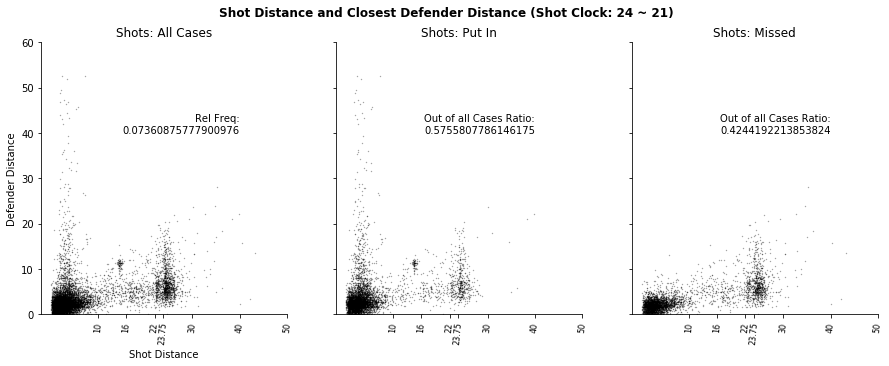

In [592]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 24 ~ 21)', fontweight = 'bold')

axs[0].scatter(df[df["SHOT_CLOCK"]>21]["SHOT_DIST"],df[df["SHOT_CLOCK"]>21]["CLOSE_DEF_DIST"],s=0.1,c='k',alpha=0.5)
freq = len(df[df["SHOT_CLOCK"]>21])
rel_freq = freq/len(df)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[(df["SHOT_CLOCK"]>21) & (df['FGM']==1)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]>21) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='k',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[(df["SHOT_CLOCK"]>21) & (df['FGM']==1)])/freq), horizontalalignment='right')

axs[2].scatter(df[(df["SHOT_CLOCK"]>21) & (df['FGM']==0)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]>21) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='k',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[(df["SHOT_CLOCK"]>21) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

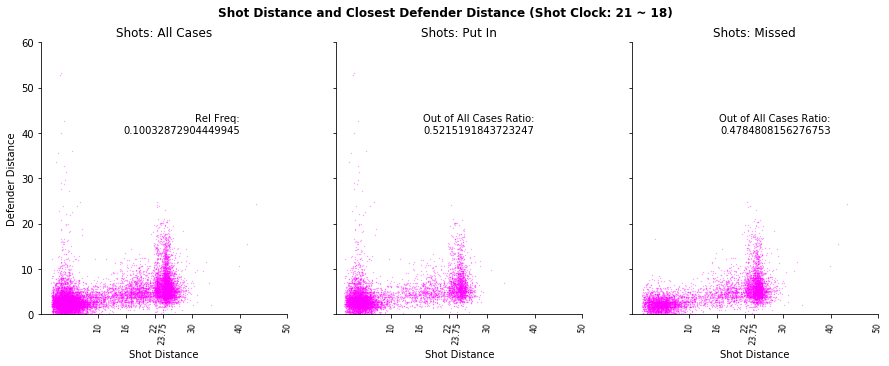

In [593]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 21 ~ 18)', fontweight = 'bold')

freq = len(df[(df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)])
rel_freq = freq/len(df)
axs[0].scatter(df[(df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)]["CLOSE_DEF_DIST"],s=0.1,c='magenta',alpha=0.5)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[((df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)) & (df['FGM']==1)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='magenta',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)) & (df['FGM']==1)])/freq), horizontalalignment='right')

axs[2].scatter(df[((df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)) & (df['FGM']==0)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='magenta',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<21) & (df["SHOT_CLOCK"]>18)) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

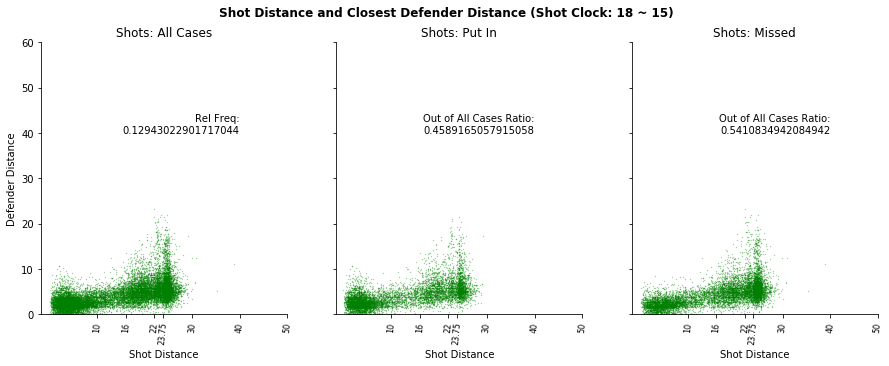

In [594]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 18 ~ 15)', fontweight = 'bold')

freq = len(df[(df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)])
rel_freq = freq/len(df)
axs[0].scatter(df[(df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)]["CLOSE_DEF_DIST"],s=0.1,c='green',alpha=0.5)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[((df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)) & (df['FGM']==1)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='green',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)) & (df['FGM']==1)])/freq), horizontalalignment='right')

axs[2].scatter(df[((df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)) & (df['FGM']==0)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='green',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<18) & (df["SHOT_CLOCK"]>15)) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

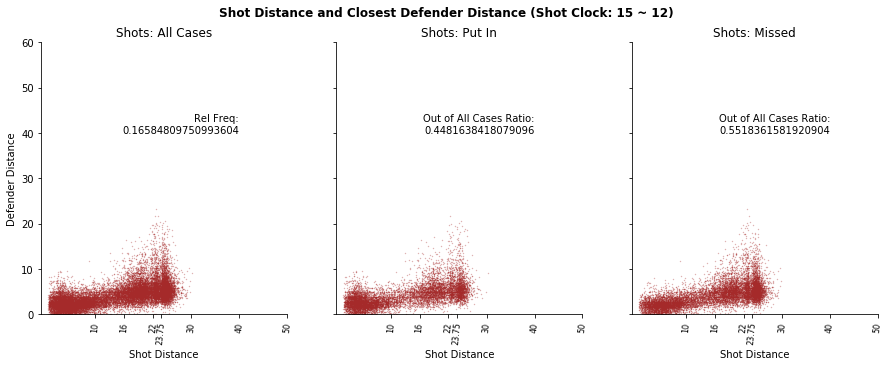

In [596]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 15 ~ 12)', fontweight = 'bold')

freq = len(df[(df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)])
rel_freq = freq/len(df)
axs[0].scatter(df[(df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)]["CLOSE_DEF_DIST"],s=0.1,c='brown',alpha=0.5)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[((df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)) & (df['FGM']==1)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='brown',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)) & (df['FGM']==1)])/freq), horizontalalignment='right')

axs[2].scatter(df[((df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)) & (df['FGM']==0)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='brown',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<15) & (df["SHOT_CLOCK"]>12)) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

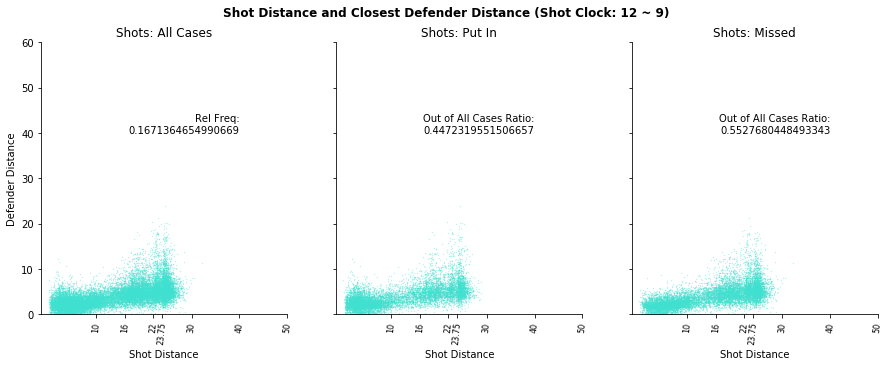

In [597]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 12 ~ 9)', fontweight = 'bold')

freq = len(df[(df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)])
rel_freq = freq/len(df)
axs[0].scatter(df[(df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)]["CLOSE_DEF_DIST"],s=0.1,c='turquoise',alpha=0.5)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[((df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)) & (df['FGM']==1)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='turquoise',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)) & (df['FGM']==1)])/freq), horizontalalignment='right')

axs[2].scatter(df[((df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)) & (df['FGM']==0)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='turquoise',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<12) & (df["SHOT_CLOCK"]>9)) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

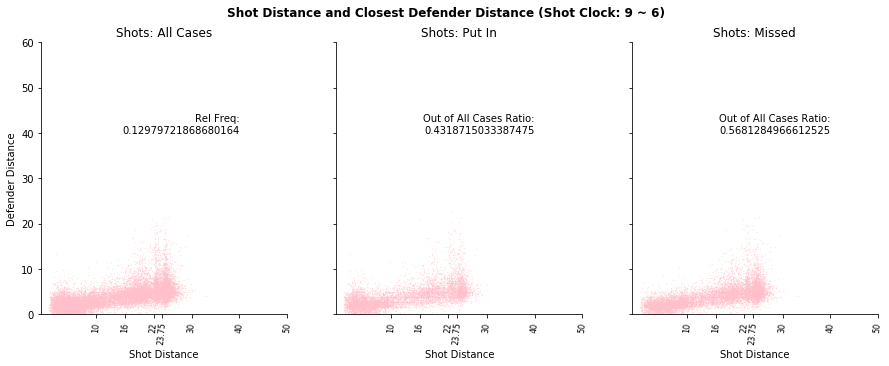

In [599]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 9 ~ 6)', fontweight = 'bold')

freq = len(df[(df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)])
rel_freq = freq/len(df)
axs[0].scatter(df[(df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)]["CLOSE_DEF_DIST"],s=0.1,c='pink',alpha=0.5)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[((df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)) & (df['FGM']==1)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='pink',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)) & (df['FGM']==1)])/freq), horizontalalignment='right')


axs[2].scatter(df[((df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)) & (df['FGM']==0)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='pink',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<9) & (df["SHOT_CLOCK"]>6)) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

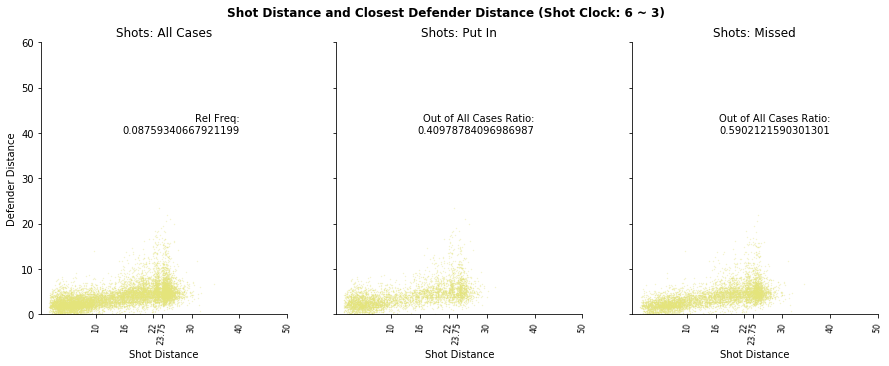

In [600]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 6 ~ 3)', fontweight = 'bold')

freq = len(df[(df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)])
rel_freq = freq/len(df)
axs[0].scatter(df[(df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)]["CLOSE_DEF_DIST"],s=0.1,c='#E4E47B',alpha=0.5)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[((df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)) & (df['FGM']==1)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='#E4E47B',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)) & (df['FGM']==1)])/freq), horizontalalignment='right')

axs[2].scatter(df[((df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)) & (df['FGM']==0)]["SHOT_DIST"],df[((df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='#E4E47B',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[((df["SHOT_CLOCK"]<6) & (df["SHOT_CLOCK"]>3)) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

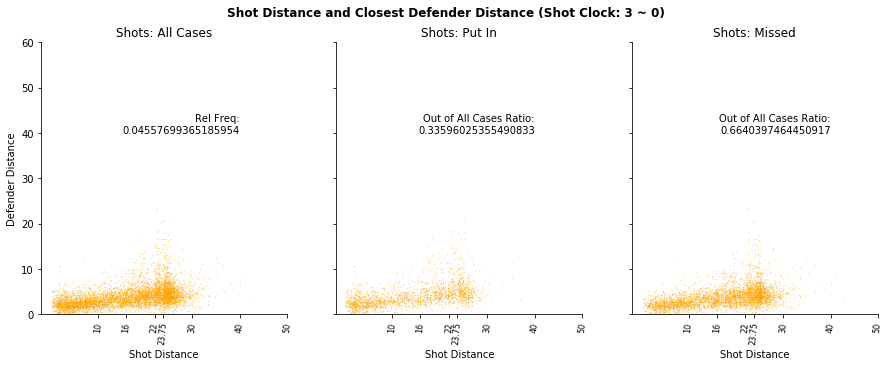

In [601]:
fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))

df = pd.read_csv("~/Downloads/shot_logs.csv")

df["player_name"] = df["player_name"].str.title()

plt.suptitle('Shot Distance and Closest Defender Distance (Shot Clock: 3 ~ 0)', fontweight = 'bold')

freq = len(df[df["SHOT_CLOCK"]<3])
rel_freq = freq/len(df)
axs[0].scatter(df[df["SHOT_CLOCK"]<3]["SHOT_DIST"],df[df["SHOT_CLOCK"]<3]["CLOSE_DEF_DIST"],s=0.1,c='orange',alpha=0.5)
axs[0].set_title('Shots: All Cases')
axs[0].set_ylabel('Defender Distance')
axs[0].set_xlabel('Shot Distance')
axs[0].set_ylim(0,60)
axs[0].set_xticks(x)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)
axs[0].text(40, 40, 'Rel Freq:\n' + str(rel_freq), horizontalalignment='right')

axs[1].scatter(df[(df["SHOT_CLOCK"]<3) & (df['FGM']==1)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<3) & (df['FGM']==1)]["CLOSE_DEF_DIST"],s=0.1,c='orange',alpha=0.5)
axs[1].set_title('Shots: Put In')
axs[1].set_xlabel('Shot Distance')
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)
axs[1].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[(df["SHOT_CLOCK"]<3) & (df['FGM']==1)])/freq), horizontalalignment='right')

axs[2].scatter(df[(df["SHOT_CLOCK"]<3) & (df['FGM']==0)]["SHOT_DIST"],df[(df["SHOT_CLOCK"]<3) & (df['FGM']==0)]["CLOSE_DEF_DIST"],s=0.1,c='orange',alpha=0.5)
axs[2].set_title('Shots: Missed')
axs[2].set_xlabel('Shot Distance')
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)
axs[2].text(40, 40, 'Out of All Cases Ratio:\n' + str(len(df[(df["SHOT_CLOCK"]<3) & (df['FGM']==0)])/freq), horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

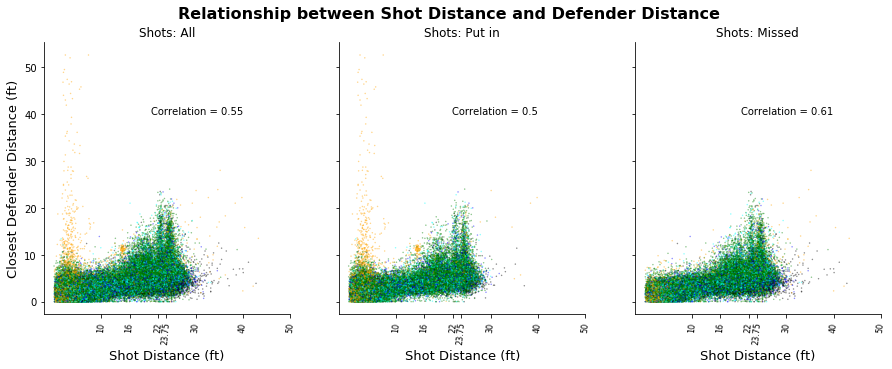

Shot Clock: 0 -------- 3 -------- 6 -------- 9 ----------------------------- 18 ------- 21 ------- 24
Color:         black       blue       cyan                 green                magenta     orange


In [301]:
df = pd.read_csv("~/Downloads/shot_logs.csv")
df = df.loc[(df["SHOT_CLOCK"]<18) | (df["SHOT_CLOCK"]>21)]

fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))
plt.suptitle("Relationship between Shot Distance and Defender Distance",fontweight='bold',fontsize=16)

x = [10,16,22,23.75,30,40,50]


col = np.where(df["SHOT_CLOCK"]<=3,'#000000', np.where(df["SHOT_CLOCK"]<=6,'#0000FF', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18,'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[0].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[0].set_title("Shots: All")
axs[0].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[0].set_ylabel("Closest Defender Distance (ft)",fontsize=13)
axs[0].set_xticks(x)
axs[0].set_ylim(0,60)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[0].text(40, 40, message, horizontalalignment='right')

df = df[df["FGM"]==1]

col = np.where(df["SHOT_CLOCK"]<=3,'k', np.where(df["SHOT_CLOCK"]<=6,'b', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18, 'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[1].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[1].set_title("Shots: Put in")
axs[1].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[1].text(40, 40, message, horizontalalignment='right')


df = pd.read_csv("~/Downloads/shot_logs.csv")
df = df.loc[(df["SHOT_CLOCK"]<18) | (df["SHOT_CLOCK"]>21)]
df = df[df["FGM"]==0]

col = np.where(df["SHOT_CLOCK"]<=3,'#000000', np.where(df["SHOT_CLOCK"]<=6,'#0000FF', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18, 'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[2].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[2].set_title("Shots: Missed")
axs[2].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[2].text(40, 40, message, horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

print("Shot Clock: 0 -------- 3 -------- 6 -------- 9 ----------------------------- 18 ------- 21 ------- 24")
print("Color:         black       blue       cyan                 green                magenta     orange")

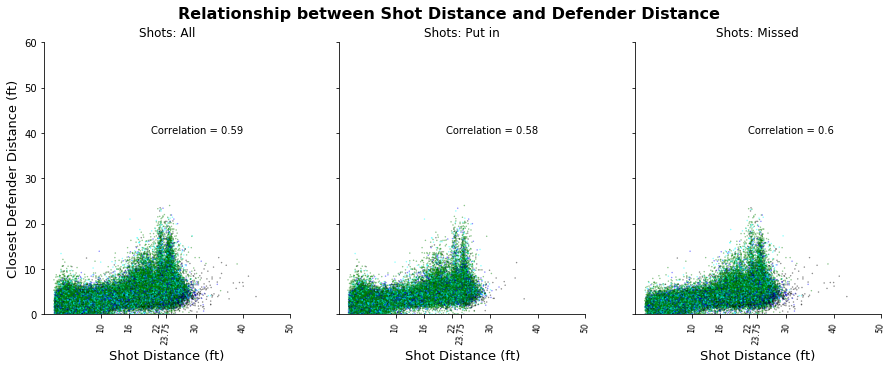

Shot Clock: 0 -------- 3 -------- 6 -------- 9 ----------------------------- 18 ------- 21 ------- 24
Color:         black       blue       cyan                 green                magenta     orange


In [307]:
df = pd.read_csv("~/Downloads/shot_logs.csv")
df = df.loc[(df["SHOT_CLOCK"]<18)]

fig, axs = plt.subplots(ncols=3,nrows=1, sharey=True, figsize=(15,5))
plt.suptitle("Relationship between Shot Distance and Defender Distance",fontweight='bold',fontsize=16)

x = [10,16,22,23.75,30,40,50]


col = np.where(df["SHOT_CLOCK"]<=3,'#000000', np.where(df["SHOT_CLOCK"]<=6,'#0000FF', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18,'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[0].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[0].set_title("Shots: All")
axs[0].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[0].set_ylabel("Closest Defender Distance (ft)",fontsize=13)
axs[0].set_xticks(x)
axs[0].set_ylim(0,60)
axs[0].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[0].text(40, 40, message, horizontalalignment='right')

df = df[df["FGM"]==1]

col = np.where(df["SHOT_CLOCK"]<=3,'k', np.where(df["SHOT_CLOCK"]<=6,'b', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18, 'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[1].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[1].set_title("Shots: Put in")
axs[1].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[1].set_xticks(x)
axs[1].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[1].text(40, 40, message, horizontalalignment='right')


df = pd.read_csv("~/Downloads/shot_logs.csv")
df = df.loc[(df["SHOT_CLOCK"]<18)]
df = df[df["FGM"]==0]

col = np.where(df["SHOT_CLOCK"]<=3,'#000000', np.where(df["SHOT_CLOCK"]<=6,'#0000FF', np.where(df["SHOT_CLOCK"]<=9,'cyan', np.where(df["SHOT_CLOCK"]<=18, 'g', np.where(df["SHOT_CLOCK"]<=21,'magenta','orange')))))

axs[2].scatter(df["SHOT_DIST"],df["CLOSE_DEF_DIST"],s=0.2,c=col,alpha=0.5)
axs[2].set_title("Shots: Missed")
axs[2].set_xlabel("Shot Distance (ft)",fontsize=13)
axs[2].set_xticks(x)
axs[2].set_xticklabels(x,rotation=85, fontsize=8)

corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
message = "Correlation = " + str(round(cr,2)) 
axs[2].text(40, 40, message, horizontalalignment='right')

plt.rc('axes.spines', **{'right':False, 'top':False})
plt.show()

print("Shot Clock: 0 -------- 3 -------- 6 -------- 9 ----------------------------- 18 ------- 21 ------- 24")
print("Color:         black       blue       cyan                 green                magenta     orange")

In [287]:
df = pd.read_csv("~/Downloads/shot_logs.csv")
corr_mat = df.corr() # This is the correlation matrix of the data series in the df
cr1 = corr_mat.SHOT_DIST.CLOSE_DEF_DIST
cr1

0.5231918411181934

In [171]:
cr2 = corr_mat.SHOT_DIST.SHOT_CLOCK
cr2

-0.1730261432073846

In [298]:
df = df.loc[(df["SHOT_CLOCK"]<18) | (df["SHOT_CLOCK"]>21)]

In [439]:
df.loc[df["CLOSEST_DEFENDER"]=='Nene','CLOSEST_DEFENDER'] = 'Nene Hilario'

In [441]:
df[df['CLOSEST_DEFENDER']=='Nene']

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,CLOSEST_DEFENDER_list,GAME_CLOCK_INT,CLOSEST_DEFENER


In [602]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,Brian Roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,Brian Roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,Brian Roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,Brian Roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,Brian Roberts,203148


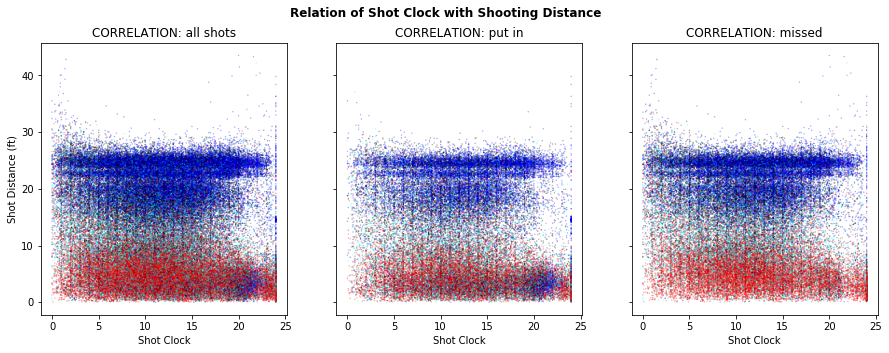

In [214]:
# Will do harder shots when shot clock is closer to 0 (long distance)
# Will do less shots when time is close to 24
    # If they do, those shots will be very close distance (middle or shooting from underneath)
# 3 point line connection with the lines showing in scatter plot?
# Specifically looking at a player. Is he more stressed/mentally strong when the shot clock is ticking towards 0?
# Hypothesis -> there is a line upwards in the time 24. The reason will be because the game clock is ticking.
    # However, in quarter 4, if winning the game, will not try the shot.
        # Will be able to compare these kinds of shots' frequency in quarters 1,2,3 and quarter 4.
# 

# col = []
# for i in range(len(df)):
#     if df["GAME_CLOCK_INT"][i] < 5:
#         col.append('r')
#     else:
#         col.append('b')
# for i in range(len(df)):
#     plt.scatter(df["SHOT_CLOCK"],df["SHOT_DIST"],c=col[i],s=0.1)

fig, axs = plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))

plt.suptitle("Relation of Shot Clock with Shooting Distance",fontweight='bold')

df = pd.read_csv("~/Downloads/shot_logs.csv")
col = np.where(df["CLOSE_DEF_DIST"]<=5,np.where(df["CLOSE_DEF_DIST"]<=3.5,np.where(df["CLOSE_DEF_DIST"]<=2.5,'r','cyan'),'k'),'b')
axs[0].scatter(df["SHOT_CLOCK"],df["SHOT_DIST"],c=col,s=0.1,alpha=0.5)
axs[0].set_title("CORRELATION: all shots")
axs[0].set_xlabel("Shot Clock")
axs[0].set_ylabel("Shot Distance (ft)")

df = df[df["FGM"]==1]
col = np.where(df["CLOSE_DEF_DIST"]<=5,np.where(df["CLOSE_DEF_DIST"]<=3.5,np.where(df["CLOSE_DEF_DIST"]<=2.5,'r','cyan'),'k'),'b')
axs[1].scatter(df["SHOT_CLOCK"],df["SHOT_DIST"],c=col,s=0.1,alpha=0.5)
axs[1].set_title("CORRELATION: put in")
axs[1].set_xlabel("Shot Clock")

df = pd.read_csv("~/Downloads/shot_logs.csv")
df = df[df["FGM"]==0]
col = np.where(df["CLOSE_DEF_DIST"]<=5,np.where(df["CLOSE_DEF_DIST"]<=3.5,np.where(df["CLOSE_DEF_DIST"]<=2.5,'r','cyan'),'k'),'b')
axs[2].scatter(df["SHOT_CLOCK"],df["SHOT_DIST"],c=col,s=0.1,alpha=0.5)
axs[2].set_title("CORRELATION: missed")
axs[2].set_xlabel("Shot Clock")
plt.show()
# col = np.where(df["PTS_TYPE"]==3,'k',np.where(df["GAME_CLOCK_INT"]<5,'r',np.where(df["SHOT_CLOCK"]<4,'green','b')))
# plt.scatter(df["CLOSE_DEF_DIST"],df["PTS_TYPE"],c=col,s=0.2)
# plt.show()
